# A Glimpse of Deep Learning

这个Lab利用MNIST数据集来给大家展示卷积神经网络（CNN）的训练过程，以及如何对于CNN模型进行调优。
同时，通过比较CPU和GPU的训练时间，让大家体会算力在Deep Learning中的作用

*NOTE*：如果你不使用Colab，就需要提前预装TensorFlow。

如果在Mac上，可以使用这个项目里的poetry，
```
poetry install
```

如果在Windows上，你需要自己探索（可以找大模型帮忙）


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam

下面这个脚本告诉你，你是否可以使用GPU进行训练

In [ ]:
import tensorflow as tf
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)

# 1. 数据加载和预处理

Tensor通用shape是(N, H, W, C)，其中N是样本数量，H是高度，W是宽度，C是通道数。
在MNIST数据集中，每个图像是28x28的灰度图，所以通道数C=1。

经验来看，图像数据通常将数据归一化到0-1之间，这样有利于模型的训练。

    **JC：为什么要除255来归一化？**


在Keras中，标签通常使用One-Hot编码，这样有利于计算分类的准确率。

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

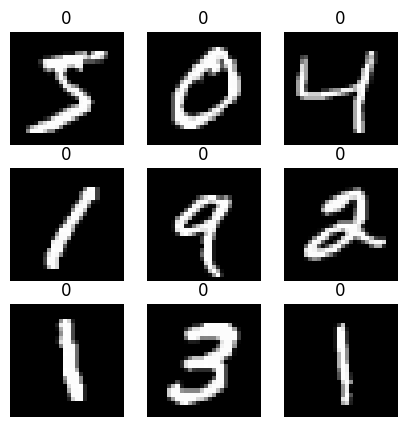

In [6]:
# 原始数据集的图像

plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray')
    plt.title(np.argmax(y_train[i]))
    plt.axis('off')
plt.show()

In [7]:
# 数据归一化
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# 标签One-Hot编码
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 2. 一个最简单的CNN

下面这个模型是一个最简单的CNN模型

    - “特征工程”：卷积层 + 池化层 + 展平层
    - “分类器”：全连接层

**JC：卷积层和池化层的作用是什么？**

**JC：卷积层的kernel_size是什么意思？池化层的pool_size是什么意思？**

**JC：卷积层的activation是什么？**

In [ ]:
# 初始化模型
model = Sequential()

# 添加卷积层
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))

# 添加池化层
model.add(MaxPooling2D(pool_size=(2, 2)))

# 展平层
model.add(Flatten())

# 全连接层
model.add(Dense(128, activation='relu'))

# 输出层， 10 对应10个类别
model.add(Dense(10, activation='softmax'))

设置训练参数，可以类比ML中的模型参数

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


默认使用CPU进行训练

In [ ]:
history = model.fit(X_train, y_train, 
validation_data=(X_test, y_test), 
epochs=5, batch_size=128)


如果你在Colab上，可以尝试使用GPU进行训练，需要修改runtime/运行时的机器类别到GPU

如果你在Mac上，上面的检测脚本告诉你有GPU，那么你可以使用GPU进行训练，看看相比CPU节约了多少

In [ ]:
with tf.device('/GPU:0'):  
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)


比较训练数据集和验证数据集的准确率，来观察是否需要调整epochs，是否有过拟合。

**JC：如果过拟合了，train loss/validation loss有会有什么模式？**

In [ ]:
# 绘制准确率曲线
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.show()

# 绘制损失曲线
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# 3. LeNet-5

LeNet-5是CNN的经典模型，在1998年由Yann LeCun提出，用于手写数字的识别。

**JC：比较LeNet-5和上面的最简单的CNN模型，有哪些区别？**

Deep Learning的模型构建就像搭乐高积木一样，通过不同的积木组合，来测试是否有更好的效果。

除了上面的这三种积木，还有RNN，Transformer，LSTM，GRU等积木。有兴趣的同学可以找到相关的paper，用大模型辅助你去复现一下

In [9]:
# 初始化模型
lenet5 = Sequential()

# 第一个卷积层和池化层
lenet5.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(28,28,1), padding='same'))
lenet5.add(MaxPooling2D(pool_size=(2, 2)))

# 第二个卷积层和池化层
lenet5.add(Conv2D(16, kernel_size=(5, 5), activation='tanh'))
lenet5.add(MaxPooling2D(pool_size=(2, 2)))

# 展平层
lenet5.add(Flatten())

# 全连接层
lenet5.add(Dense(120, activation='tanh'))
lenet5.add(Dense(84, activation='tanh'))

# 输出层
lenet5.add(Dense(10, activation='softmax'))

In [10]:
# 使用SGD优化器
optimizer = SGD(learning_rate=0.01)
lenet5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history_lenet5 = lenet5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)


**JC：读了这张图，你会如何决策下一步训练？**

In [ ]:
# 绘制准确率曲线
plt.plot(history_lenet5.history['accuracy'], label='LeNet-5_train_accuracy')
plt.plot(history_lenet5.history['val_accuracy'], label='LeNet-5_validation_accuracy')
plt.legend()
plt.show()


In [ ]:
loss, accuracy = lenet5.evaluate(X_test, y_test)
print(f'LeNet-5 Test Loss: {loss}')
print(f'LeNet-5 Test Accuracy: {accuracy}')


# 3. 炼一炉丹

和ML选型相对还有一些数学直觉和验证之外，DL的参数选型的反馈只有通过数据集的验证才能看到结果。这种方式非常接近中世纪化学发明前的Alchemy，所以DL也被称为“炼金术”，DL研究人员戏称自己为“炼丹师”。

你可以挑选一些参数，来观察他们的变化对模型训练的影响。
    - 模型架构：增加卷积层，改变activation方式，改变kernel size和stride
    - 优化器：SGD，Adam[基本是标配]，AdamW；学习速率
    - 损失函数：categorical_crossentropy[基本是标配]，MSE
    - 训练过程：epochs，batch size

**JC：尝试选择变更一个参数，看看效果如何**